# Figure 9

## Imports

In [58]:
import matplotlib.pyplot as plt
import numpy
import os
import dolfin
import get_invariants_article_gravity 
import meshio
import shutil

import dolfin_mech                    as dmech


import importlib
importlib.reload(get_invariants_article_gravity)


<module 'get_invariants_article_gravity' from '/Users/peyrault/gravity-modeling-papers-demo/demos/get_invariants_article_gravity.py'>

## Creating folder for temporary files

In [59]:
current_directory=os.getcwd()
new_directory="calc_fig9"
res_basename = os.path.join(current_directory, new_directory)

try:
    shutil.rmtree(res_basename)
except OSError:
    pass

os.mkdir(res_basename)

clean_upon_completion=True

## Parameters

In [60]:
alpha = 0.16
gamma = 0.5
c1 = 0.6
c2 = 0. ## obsolete parameter
rho_solid =  1.06e-6


params = {
        "alpha": alpha,
        "gamma":gamma,
        "c1":c1,
        "c2":c2,
        "kappa":1e2,
        "eta":1e-5,
        "rho_solid":rho_solid}

mat_params = {"scaling":"linear", "parameters": params}

## Loading

In [61]:
pe, pi = -0.5, -2. ### pleural pressure values 

gravity_lst=[-1,1]

# breathing_constants=[0, -0.005, 0.005, -0.0065, 0.0065] ### different types of breathing

## Mesh

In [62]:
cube_params = {"path_and_mesh_name" : str(current_directory)+"/Meshes/generic_lung.xdmf"}


## Computing end-exhalation and end-inhalation configurations in prone and supine positions

In [63]:
invariants={}
for gravity_cste in gravity_lst:

    load_params_inverse = {
        "type":"p_boundary_condition0", "f": gravity_cste*9.81e3, "P0" : float(pe)}
    load_params_direct_exhalation = {
        "type":"p_boundary_condition", "f": gravity_cste*9.81e3, "P0" : float(pe)}
    load_params_direct_inhalation = {
        "type":"p_boundary_condition", "f": gravity_cste*9.81e3, "P0" : float(pi)}


    ##### computing the reference configuration, trough an inverse problem
    Uref, phisref_computation, V_expi_ini, V_unloaded = dmech.run_RivlinCube_PoroHyperelasticity(
            inverse=1,
            mat_params=mat_params,
            load_params=load_params_inverse,
            get_results=1,
            inertia=1,
            step_params={"dt_min":1e-4, "dt_ini":1},
            res_basename=res_basename+"/reference",
            cube_params=cube_params,
            verbose=1)

    ##### assuming that porosity is uniform in the unloaded configuration, and taking the same starting values for the problem with and the problem without gravity 

    phisref_imposed=[numpy.random.uniform(low=0.4, high=0.6) for i in range(len(phisref_computation))]

    U_exhal, phisexhal_g, V_unloaded, V_exhal = dmech.run_RivlinCube_PoroHyperelasticity(
                inverse=0,
                mat_params=mat_params,
                load_params=load_params_direct_exhalation,
                get_results=1,
                inertia=1,
                step_params={"dt_min":1e-4, "dt_ini":0.125},
                res_basename = res_basename+"/exhalation",
                cube_params=cube_params,
                porosity_params={"type": "function_xml_from_array", "val":phisref_imposed},
                move = {"move":True, "U":Uref},
                verbose=1)
        

    U_inhal, phisinhal, V_unloaded, Vinhal = dmech.run_RivlinCube_PoroHyperelasticity(
            inverse=0,
            mat_params=mat_params,
            load_params=load_params_direct_inhalation,
            get_results=1,
            inertia=1,
            step_params={"dt_min":1e-4, "dt_ini":0.125},
            res_basename = res_basename+"/inhalation",
            cube_params=cube_params,
            porosity_params={"type": "function_xml_from_array", "val":phisref_imposed},
            move = {"move":True, "U":Uref},
            verbose=1)

    mesh = dolfin.Mesh()
    mesh_name = str(cube_params["path_and_mesh_name"])
    dolfin.XDMFFile(mesh_name).read(mesh)
    dolfin.ALE.move(mesh, Uref)

    invariants_mesh = get_invariants_article_gravity.get_invariants(U_exhal=U_exhal, U_inhal=U_inhal, mesh=mesh, lognorm=False)
    invariants["g="+str(gravity_cste)]=invariants_mesh

Iterating over subset, found 310 entities out of 4052.
Iterating over subset, found 248 entities out of 4052.
Iterating over subset, found 356 entities out of 4052.
Iterating over subset, found 328 entities out of 4052.
Iterating over subset, found 371 entities out of 4052.
Iterating over subset, found 516 entities out of 4052.
Iterating over subset, found 445 entities out of 4052.
Iterating over subset, found 526 entities out of 4052.
Iterating over subset, found 481 entities out of 4052.
Iterating over subset, found 471 entities out of 4052.
Iterating over subset, found 354 entities out of 4052.
Iterating over subset, found 288 entities out of 4052.
Iterating over subset, found 308 entities out of 4052.
Iterating over subset, found 354 entities out of 4052.
Iterating over subset, found 444 entities out of 4052.
Iterating over subset, found 438 entities out of 4052.
Iterating over subset, found 489 entities out of 4052.
Iterating over subset, found 521 entities out of 4052.
Iterating 

In [64]:
if clean_upon_completion:
    shutil.rmtree(res_basename, ignore_errors=1)

## Post-processing

### Reading displacement field from Patte et al. and computing associated invariants

In [65]:
mesh = dolfin.Mesh()
dolfin.XDMFFile("Meshes/mesh_patte.xdmf").read(mesh)
fe = dolfin.VectorElement(
    family="CG",
    cell=mesh.ufl_cell(),
    degree=1)
U_fs= dolfin.FunctionSpace(
    mesh,
    fe)

U_inhal_patte = dolfin.Function(U_fs, name="U")
U_exhal_patte = dolfin.Function(U_fs, name="U")

mesh_meshio = meshio.read("Meshes/mesh_patte.xdmf")
u_meshio = mesh_meshio.point_data["U"]
u_meshio = u_meshio.tolist()
u_meshio = [item for sublist in u_meshio for item in sublist] 

c=0
for dof in dolfin.vertex_to_dof_map(U_fs):
    U_inhal_patte.vector()[dof] = u_meshio[c]
    U_exhal_patte.vector()[dof] = 0
    c +=1

In [66]:
invariants_mesh_patte = get_invariants_article_gravity.get_invariants(U_exhal=U_exhal_patte, U_inhal=U_inhal_patte, mesh=mesh, lognorm=False)

Iterating over subset, found 375 entities out of 4052.
Iterating over subset, found 314 entities out of 4052.
Iterating over subset, found 315 entities out of 4052.
Iterating over subset, found 329 entities out of 4052.
Iterating over subset, found 384 entities out of 4052.
Iterating over subset, found 440 entities out of 4052.
Iterating over subset, found 425 entities out of 4052.
Iterating over subset, found 520 entities out of 4052.
Iterating over subset, found 453 entities out of 4052.
Iterating over subset, found 497 entities out of 4052.


### Generating plots

#### J

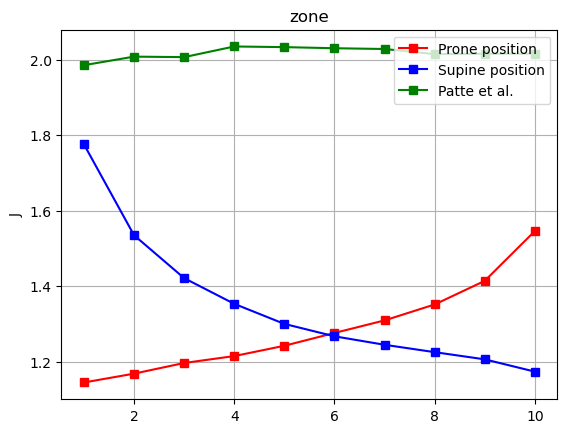

In [67]:
figJ, axJ = plt.subplots()


plt.plot(invariants["g=-1"]["zone"], invariants["g=-1"]["J"], color='red', linestyle='-', marker="s", label='Prone position')
plt.plot(invariants["g=1"]["zone"], invariants["g=1"]["J"], color='blue', linestyle='-', marker="s", label='Supine position')
plt.plot(invariants_mesh_patte["zone"], invariants_mesh_patte["J"], color='green', linestyle='-', marker="s", label='Patte et al.')

axJ.set_ylabel('J')
axJ.set_title('zone')

plt.grid()
plt.legend(loc="upper right")
plt.show()


#### I1

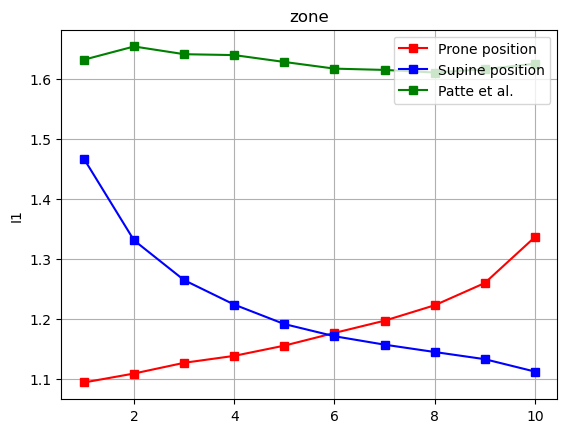

In [68]:
figJ, axJ = plt.subplots()


plt.plot(invariants["g=-1"]["zone"], invariants["g=-1"]["I1"], color='red', linestyle='-', marker="s", label='Prone position')
plt.plot(invariants["g=1"]["zone"], invariants["g=1"]["I1"], color='blue', linestyle='-', marker="s", label='Supine position')
plt.plot(invariants_mesh_patte["zone"], invariants_mesh_patte["I1"], color='green', linestyle='-', marker="s", label='Patte et al.')

axJ.set_ylabel('I1')
axJ.set_title('zone')

plt.legend(loc="upper right")
plt.grid()
plt.show()


#### I2

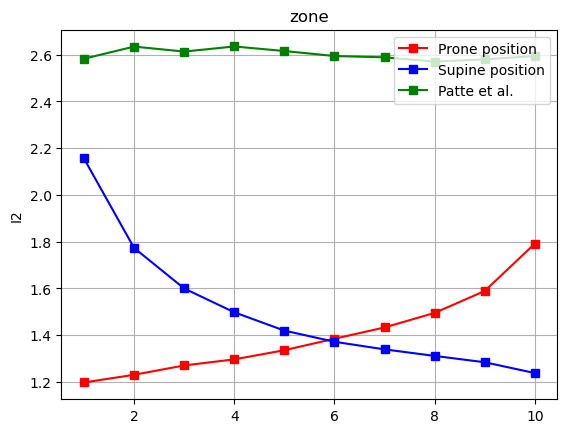

In [69]:
figJ, axJ = plt.subplots()


plt.plot(invariants["g=-1"]["zone"], invariants["g=-1"]["I2"], color='red', linestyle='-', marker="s", label='Prone position')
plt.plot(invariants["g=1"]["zone"], invariants["g=1"]["I2"], color='blue', linestyle='-', marker="s", label='Supine position')
plt.plot(invariants_mesh_patte["zone"], invariants_mesh_patte["I2"], color='green', linestyle='-', marker="s", label='Patte et al.')


plt.legend(loc="upper right")

axJ.set_ylabel('I2')
axJ.set_title('zone')

plt.grid()
plt.show()
